In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score,StratifiedKFold,KFold
from sklearn.feature_selection import SelectKBest,f_classif,SelectFdr
from sklearn import svm
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize,RobustScaler,StandardScaler
from sklearn.cluster import KMeans
from lifelines import CoxPHFitter
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import glorot_uniform,RandomUniform,Constant
from scipy.stats import spearmanr
import statistics

GDSC

In [2]:
# load the genes from GDSC
genes = pd.read_csv("genes_GDSC_oxa.csv")
genes

,Unnamed: 0,Unnamed: 0.1
0,0,TSPAN6
1,1,DPM1
2,2,SCYL3
3,3,FGR
4,4,CFH
...,...,...
10227,10227,LINC00657
10228,10228,MIA
10229,10229,LINC00514
10230,10230,LINC00526


IMPRESS

In [3]:
# load GSE data expression
impress = pd.read_csv("cellNorm22cpm_input.csv")
impress = impress.set_index(['Unnamed: 0'])
impress

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC00514,OR1D5,ZNF234,MYH4,LINC00526,PPY2,KRT18P55,POLRMTP1,UBL5P2,TBC1D3P5
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
GS.802,6.142303,-1.761883,6.238693,4.615545,5.067942,0,-3.160422,4.850279,4.468255,5.393102,...,-3.160422,0,4.604734,0,2.893857,0,-2.532397,-0.244829,-2.532397,0
GS.295,6.081011,-3.160422,6.178049,4.665697,4.582609,0,1.039597,5.234283,4.294598,5.008302,...,-2.421923,0,3.264026,0,3.206767,0,-3.160422,-3.160422,-3.160422,0
GS.598,5.973943,-3.160422,5.411198,4.489564,4.494100,0,3.840939,5.467636,4.686699,5.826187,...,-3.160422,0,4.646519,0,2.456218,0,-3.160422,-3.160422,-2.764020,0
GS.359,5.697562,-3.160422,5.937262,4.208244,3.829931,0,-3.160422,6.117203,4.836042,5.841040,...,-3.160422,0,4.232245,0,1.816724,0,-3.160422,-2.400742,-3.160422,0
GS.786,5.534586,-2.717335,5.860319,4.445250,4.972458,0,2.181070,6.685488,4.396504,5.720995,...,-3.160422,0,3.648075,0,1.381194,0,-2.378835,1.058050,-2.104858,0
GS.799,6.832313,-1.506272,6.099326,4.401022,4.952996,0,6.942056,6.012090,5.007873,5.762113,...,-3.160422,0,4.106370,0,2.540023,0,-3.160422,0.457079,-1.776078,0
GS.502,5.517285,-1.941725,5.348823,4.242534,4.558786,0,4.096808,5.770738,3.496134,5.773677,...,-1.941725,0,4.769770,0,2.892096,0,-2.747000,1.270810,-2.747000,0
GS.828,5.712526,-2.597850,5.365842,4.375322,4.352902,0,3.173043,4.802271,4.142446,5.111402,...,-2.597850,0,4.326297,0,2.165317,0,-3.160422,1.233941,-2.597850,0
GS.507,5.523846,-3.160422,5.573481,4.601000,4.862926,0,-0.124912,5.597672,3.868460,4.977976,...,-0.124912,0,4.019358,0,1.337705,0,-3.160422,-3.160422,-3.160422,0


In [4]:
# make the order of genes consistent to GDSC
impress = impress.reindex(columns = genes["Unnamed: 0.1"])
impress

Unnamed: 0.1,TSPAN6,DPM1,SCYL3,FGR,CFH,FUCA2,GCLC,NFYA,NIPAL3,ENPP4,...,CUX1,UBE2CP1,CEP95,SMIM6,MRPL46,LINC00657,MIA,LINC00514,LINC00526,UBL5P2
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
GS.802,6.142303,6.238693,4.615545,0,-3.160422,4.850279,4.468255,5.393102,5.446554,-3.160422,...,7.819895,-2.532397,5.501986,-3.160422,2.501663,0,-3.160422,-3.160422,2.893857,-2.532397
GS.295,6.081011,6.178049,4.665697,0,1.039597,5.234283,4.294598,5.008302,6.812552,4.682596,...,6.545577,-2.421923,5.193600,-3.160422,2.078524,0,-3.160422,-2.421923,3.206767,-3.160422
GS.598,5.973943,5.411198,4.489564,0,3.840939,5.467636,4.686699,5.826187,4.771343,3.654974,...,8.616746,-1.792433,5.079695,-2.197937,2.597804,0,-2.453390,-3.160422,2.456218,-2.764020
GS.359,5.697562,5.937262,4.208244,0,-3.160422,6.117203,4.836042,5.841040,7.013301,-0.172891,...,7.803821,-3.160422,5.086990,-2.400742,1.967320,0,-0.611540,-3.160422,1.816724,-3.160422
GS.786,5.534586,5.860319,4.445250,0,2.181070,6.685488,4.396504,5.720995,5.289655,-0.567512,...,7.888661,-2.717335,4.894639,-3.160422,1.803000,0,-3.160422,-3.160422,1.381194,-2.104858
GS.799,6.832313,6.099326,4.401022,0,6.942056,6.012090,5.007873,5.762113,5.245620,5.378579,...,7.123841,-3.160422,5.558449,-3.160422,2.951844,0,-1.279063,-3.160422,2.540023,-1.776078
GS.502,5.517285,5.348823,4.242534,0,4.096808,5.770738,3.496134,5.773677,6.810392,-2.747000,...,8.805369,-2.747000,4.836883,-3.160422,2.356808,0,-2.163655,-1.941725,2.892096,-2.747000
GS.828,5.712526,5.365842,4.375322,0,3.173043,4.802271,4.142446,5.111402,6.967383,-3.160422,...,8.091318,-1.879050,5.155250,-1.879050,2.215886,0,-2.194139,-2.597850,2.165317,-2.597850
GS.507,5.523846,5.573481,4.601000,0,-0.124912,5.597672,3.868460,4.977976,6.654832,-3.160422,...,7.921730,-0.124912,5.306239,-0.124912,-0.124912,0,-3.160422,-0.124912,1.337705,-3.160422


In [5]:
# load AUC
auc = pd.read_csv("tmz paper_screening data and survival data_IN_12Nov21.csv")
auc = auc.set_index(['GS.number'])
auc = auc.reindex(impress.index)
auc

,GT.code,PFS_months,OS_months,TMZ_IC50(uM),AUC,% cell viability_100uM TMZ,MGMT_status_tumor,MGMT_status_culture
Unnamed: 0,,,,,,,,
GS.802,GT-03-38-01-WT-02,15.9,29.0,12.7,7348,22.42,Methylated,Unmethylated
GS.295,GT-03-50-01-WT-02,6.0,35.7,17.9,10456,31.00,Unmethylated,Methylated
GS.598,GT-03-02-01-WT-02,6.3,7.4,39.7,13565,36.33,Methylated,Unmethylated
GS.359,GT-03-51-01-WT-02,36.4,37.4,88.6,17673,38.00,Methylated,Methylated
GS.786,GT-03-07-01-WT-02,1.9,2.8,104.7,18229,50.07,Methylated,Methylated
GS.799,GT-03-08-01-WT-02,5.7,7.9,166.7,20589,57.53,Unmethylated,Methylated (weak)
GS.502,GT-03-24-01-WT-02,6.2,22.0,263.5,23345,69.00,Methylated,Methylated
GS.828,GT-03-42-01-WT-02,8.4,10.0,264.1,24481,70.25,Unmethylated,Methylated
GS.507,GT-03-25-01-WT-02,13.0,27.0,60.0,27070,72.43,Methylated,NaN


(array([1., 1., 1., 3., 1., 4., 4., 2., 1., 4.]),
 array([ 7348., 10265., 13182., 16099., 19016., 21933., 24850., 27767.,
        30684., 33601., 36518.]),
 <BarContainer object of 10 artists>)

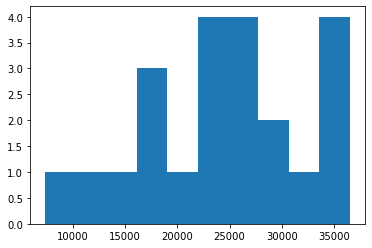

In [6]:
# AUC distribution
plt.hist(auc.AUC)

(array([1., 1., 1., 3., 1., 4., 4., 2., 1., 4.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

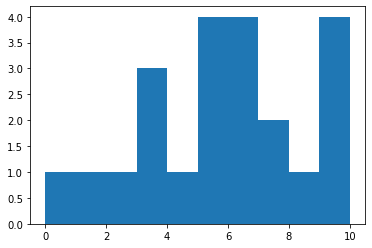

In [7]:
# linear transform AUC into range [0,10]
auc_norm = auc.AUC
auc_norm = (auc_norm - auc_norm.max())/(auc_norm.max() - auc_norm.min())+1
auc_norm = auc_norm*10
plt.hist(auc_norm)

In [8]:
# create a basic DL model

seed_num = 1000
init = RandomUniform(seed = seed_num)

def create_model(activation1 = "sigmoid",activation2="softplus",l2 = 0.001,l1=0.001,opt = tf.keras.optimizers.Adam(learning_rate= 0.0001)):
     
    model = Sequential()
    
    model.add(Dense(1000,activation= activation1,input_shape=(10232,),
                    kernel_regularizer=regularizers.l2(l2),
                    activity_regularizer=regularizers.l1(l1),
                    kernel_initializer= init))       
    
    model.add(Dropout(0.3))
    
    model.add(Dense(100, activation=activation2,kernel_initializer= init))
                    
    model.add(Dropout(0.1))
    
    model.add(Dense(1, activation= activation2))
        
    model.compile(loss='mean_squared_error',optimizer = opt,metrics=['mae']) #SGD
        
    return model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
# plot loss function
def plt_loss(train_loss,validate_loss,fold_no):
    plt.figure(figsize=(8, 8))
    #plt.subplot(5, 1, fold_no)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(validate_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    #plt.ylim([0,0.6])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [10]:
# load pre-trained HGCC weights
pre_model = create_model()
pre_model.load_weights("HGCC_model_only.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
# normalize and predict GSE AUC with the pre-trained weights without fine-tune
Standard = StandardScaler()
impress_norm = Standard.fit_transform(impress)
pred_auc = pre_model.predict(impress_norm)

In [12]:
# correlation
spearmanr(auc_norm,pred_auc)

SpearmanrResult(correlation=-0.11914172783738003, pvalue=0.5974355927153713)

In [14]:
# create a DL model and load pre-trained weights on the first layer
def create_model2(activation1 = "sigmoid",activation2 = "softplus",l2 = 0.0001,l1=0.0001,opt = tf.keras.optimizers.Adam(learning_rate= 0.0001)):
    
    model = Sequential()
    
    model.add(Dense(1000,activation= activation1,input_shape=(10232,),
                    kernel_regularizer=regularizers.l2(l2),
                    activity_regularizer=regularizers.l1(l1),
                    weights = [pre_model.layers[0].get_weights()[0],pre_model.layers[0].get_weights()[1]]))            
    
    model.add(Dropout(0.3))
    
    model.add(Dense(100, activation=activation2,
                    kernel_initializer=init
                   )
             )
                    
    model.add(Dropout(0.1))
    
    model.add(Dense(1, activation= activation2, kernel_initializer=init))
        
    model.compile(loss='mse',
                  optimizer = opt,
                  metrics=['mean_absolute_error'])
        
    return model

In [17]:
# use the same partition on the dataset to ensure a fair evaluation
train_test_index = pd.read_csv("train_test_index_sort.txt", sep="[", header=None)

line = 0

train_index = [0] * 10
test_index = [0] * 10

for seed in range(0,10):
    
    train_index[seed] = [0] * 3
    test_index[seed] = [0] * 3
    
    for fold in range(0,3):
        
        # get index train
        train_index[seed][fold] = train_test_index[1][line].split()
        # string to int
        train_index[seed][fold] = [eval(i) for i in train_index[seed][fold]]
        
                # get index train
        test_index[seed][fold] = train_test_index[2][line].split()
        # string to int
        test_index[seed][fold] = [eval(i) for i in test_index[seed][fold]]
        
        line += 1

train_index

[[[0, 1, 3, 4, 7, 8, 10, 11, 12, 13, 14, 16, 17, 20],
  [0, 2, 5, 6, 8, 9, 10, 11, 13, 15, 17, 18, 19, 20, 21],
  [1, 2, 3, 4, 5, 6, 7, 9, 12, 14, 15, 16, 18, 19, 21]],
 [[0, 2, 3, 5, 7, 10, 11, 13, 14, 15, 16, 18, 20, 21],
  [0, 1, 4, 6, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 17, 19, 21]],
 [[1, 2, 3, 5, 6, 9, 10, 12, 14, 15, 17, 18, 20, 21],
  [0, 1, 4, 5, 7, 8, 10, 11, 12, 13, 14, 16, 18, 19, 21],
  [0, 2, 3, 4, 6, 7, 8, 9, 11, 13, 15, 16, 17, 19, 20]],
 [[0, 3, 4, 6, 7, 8, 9, 11, 13, 15, 16, 17, 18, 21],
  [0, 1, 2, 4, 5, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20],
  [1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 19, 20, 21]],
 [[0, 2, 5, 6, 7, 8, 10, 11, 13, 15, 16, 18, 19, 20],
  [1, 2, 3, 4, 7, 9, 11, 12, 13, 14, 15, 17, 18, 20, 21],
  [0, 1, 3, 4, 5, 6, 8, 9, 10, 12, 14, 16, 17, 19, 21]],
 [[0, 1, 2, 4, 5, 8, 9, 11, 12, 14, 15, 19, 20, 21],
  [0, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 20],
  [1, 2, 3, 5, 6, 7, 10, 11, 13, 15, 16, 17, 

In [ ]:
##### 3-fold CV to evaluate the model performance ####

# initiate the list of results
overall_cor_res = []

# 10 partitions
for k in range(0,10):
    
    exp_train = [0]*3
    exp_test = [0]*3
    auc_train = [0]*3
    auc_test = [0]*3
    pred_res = []
    # plot loss
    loss = []
    val_loss = []
    mse = []
    val_mse = []
    
    # 3-fold CV
    for fold_no in range(0,3):
    
        # split dataset
        exp_train[fold_no], exp_test[fold_no] = impress.iloc[train_index[k][fold_no],:], impress.iloc[test_index[k][fold_no],:]
        auc_train[fold_no], auc_test[fold_no] = auc_norm[train_index[k][fold_no]], auc_norm[test_index[k][fold_no]]
    
    
        # normalize
        exp_train[fold_no] = Standard.fit_transform(exp_train[fold_no])
        exp_test[fold_no] = Standard.fit_transform(exp_test[fold_no])
    
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {(fold_no+1)}, seed {(k+1)} ...')
    
        # Create a basic model instance
        pred_model = create_model2(l2 = 0.0001,l1=0.0001,opt = tf.keras.optimizers.Adam(lr = 0.001))
    
        refine_model = pred_model.fit(x=exp_train[fold_no], y=auc_train[fold_no], epochs=50, batch_size=32,
                                  validation_data=(exp_test[fold_no],auc_test[fold_no])
                                 )
        

    
        # predict and evaluate
        pred = pred_model.predict(exp_test[fold_no])
        pred = pd.DataFrame(pred)
        pred_res.append(pred)
        test = auc_test[fold_no].reset_index(drop = True)
        
    
        # calculate Spearman's correlation
        corr, _ = spearmanr(test, pred[0])
        print('Spearman correlation: %.3f' % corr)
    
        plt.figure(figsize=(8, 8))
        plt.scatter(test,pred[0])
        plt.plot([0, 10], [0, 10], 'k-', lw=2)
    
        # plot loss train and validate
        loss.append(refine_model.history['loss'])
        val_loss.append(refine_model.history['val_loss'])
        plt_loss(loss[fold_no],val_loss[fold_no],fold_no+1)
    
        # plot acc train and validate
        mse.append(refine_model.history['mean_absolute_error'])
        val_mse.append(refine_model.history['val_mean_absolute_error'])
        plt_loss(mse[fold_no],val_mse[fold_no],fold_no+1)


    
    # test_all
    test_all = np.concatenate([auc_test[0],auc_test[1],auc_test[2]]
    # pred_all 
    pred_all = np.concatenate([pred_res[0],pred_res[1],pred_res[2]])
    overall_cor, _ = spearmanr(test_all, pred_all)
    overall_cor_res.append(overall_cor)
    print('Overall spearman correlation: %.3f' % overall_cor)
    
